In [4]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import xgboost as xgb
import shap
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from feature_transforms import fill_nan

dataset_path = "./../../data/raw/train.csv"
submission_dataset_path = "./../../data/raw/test.csv"
timestamp_column = "measurement_time"

In [2]:
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

submission_data = pd.read_csv(
    submission_dataset_path,
    parse_dates=[timestamp_column],
)

data = fill_nan(data)
submission_data = fill_nan(submission_data)

In [3]:
y = data["target"].values
X = data.copy()
X["day_of_week"] = X["measurement_time"].dt.dayofweek  # Monday=0, Sunday=6
X["hour"] = X["measurement_time"].dt.hour
X["is_working_day"] = X["day_of_week"].apply(lambda x: 1 if x < 5 else 0)
X["is_working_hour"] = X["hour"].apply(lambda x: 1 if x >= 6 and x <= 17 else 0)

In [5]:
X = X.drop(columns=["target", "ID", "measurement_time", "day_of_week", "hour"])

numerical_cols = X.columns.difference(['is_working_day', 'is_working_hour'])
scaler = MinMaxScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [25]:
# Find first Monday at 00:00 in the last 20% of data
val_size = int(len(X) * 0.2)
start_idx = len(X) - val_size
while start_idx < len(X):
    if data.iloc[start_idx]['measurement_time'].dayofweek == 0 and data.iloc[start_idx]['measurement_time'].hour == 0:
        break
    start_idx += 1

# Split at the first Monday 00:00
X_train = X.iloc[:start_idx]
X_val = X.iloc[start_idx:]
y_train = y[:start_idx]
y_val = y[start_idx:]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Validation set starts at: {data.iloc[start_idx]['measurement_time']}")

Training set shape: (5664, 16)
Validation set shape: (1383, 16)
Validation set starts at: 2024-06-24 00:00:00


In [26]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
model = GradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    criterion='friedman_mse',  # default criterion for regression
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Make predictions and calculate MAE
train_preds = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_preds)
print(f"Training MAE: {train_mae:.4f}")

Training MAE: 1.7660


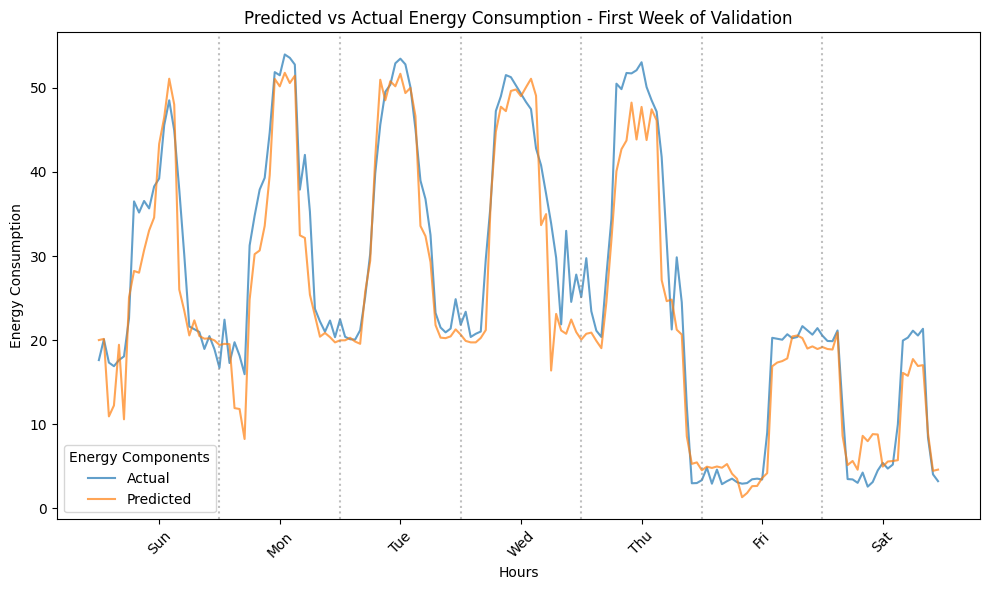

In [27]:
# Make predictions on validation set
val_preds = model.predict(X_val)

# Plot predictions vs actual for first week
plt.figure(figsize=(10, 6))

# Get first week of data (168 hours = 7 days * 24 hours)
y_val_week = y_val[:168] 
val_preds_week = val_preds[:168]

plt.plot(y_val_week, label='Actual', alpha=0.7)
plt.plot(val_preds_week, label='Predicted', alpha=0.7)

# Add vertical dotted lines to separate days
for day in range(1, 7):  # Add lines between days (after day 1 through 6)
    plt.axvline(x=day*24, color='gray', linestyle=':', alpha=0.5)

plt.title('Predicted vs Actual Energy Consumption - First Week of Validation')
plt.xlabel('Hours')
plt.ylabel('Energy Consumption')
plt.legend(title='Energy Components')

days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
plt.xticks(np.arange(12, 168, 24), days, rotation=45)
plt.tight_layout()


In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'SHAP Value': np.abs(shap_values).mean(axis=0)
})
feature_importance = feature_importance.sort_values('SHAP Value', ascending=False)
print("\nAverage absolute SHAP values per feature:")
print(feature_importance)


Average absolute SHAP values per feature:
                        Feature  SHAP Value
15              is_working_hour    3.850268
14               is_working_day    3.122072
3          source_4_temperature    1.958047
2          source_3_temperature    1.411206
1          source_2_temperature    1.332792
5            sun_radiation_east    0.976292
4         mean_room_temperature    0.931636
10          outside_temperature    0.788549
6            sun_radiation_west    0.398879
0          source_1_temperature    0.323370
7           sun_radiation_south    0.309838
11                   wind_speed    0.167612
12               wind_direction    0.159002
8           sun_radiation_north    0.127747
9   sun_radiation_perpendicular    0.095455
13                       clouds    0.042637


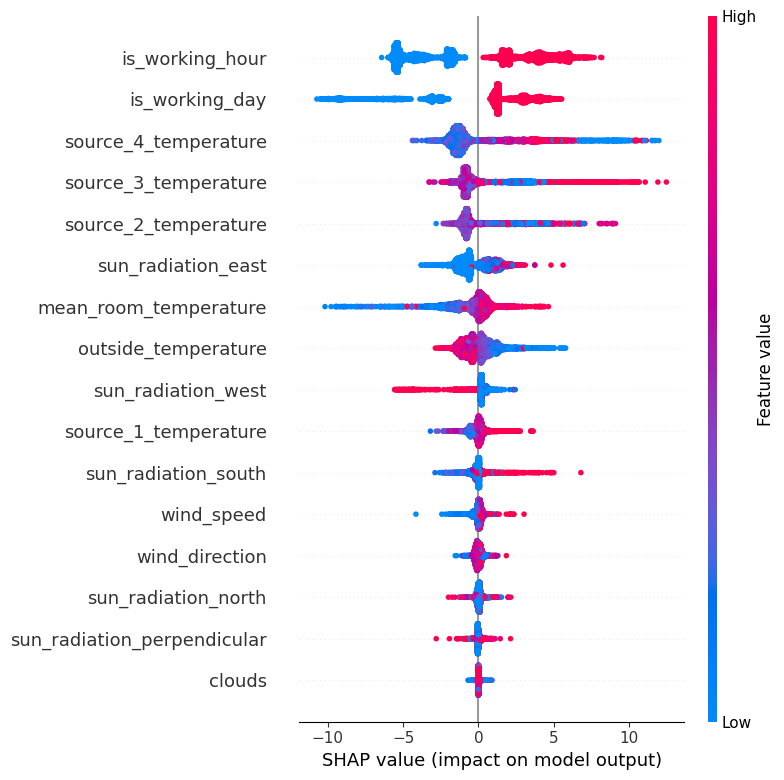

In [29]:
# Usage:
# The most influential features appear at the top of the plot
# Each point on the plot represents a single instance in your dataset
# Start by looking at the color of the dots, pink = the source very hot, blue = cold, purple = medium temperature
# The horizontal position of each point shows the SHAP value (more to the right = makes energy consumption go up, more to the left = makes energy consumption go down, central = no effect)
shap.summary_plot(shap_values, X_train)

## Interpretation of the shap ditributions
- Cooling units (2 and 3) make you consume more energy if their temperature is very high or very low, while if their temp is in the middle (purple points) I would say they dont have a big impact 
- Heating units (1 and 4) differ a bit: 4 is similar to the cooling units in a sense that it seems to consume more energy if it's at extreme temperatures but doesnt have a big impact if it has a mid temperature, while 1 consumes a lot of energy if it's hot but also predicts very well that the energy consumption is low if it has a low temperature. My guess is that this heating unit is used inside the room, see also further down for confirmation. No idea what's happening in 4 though.


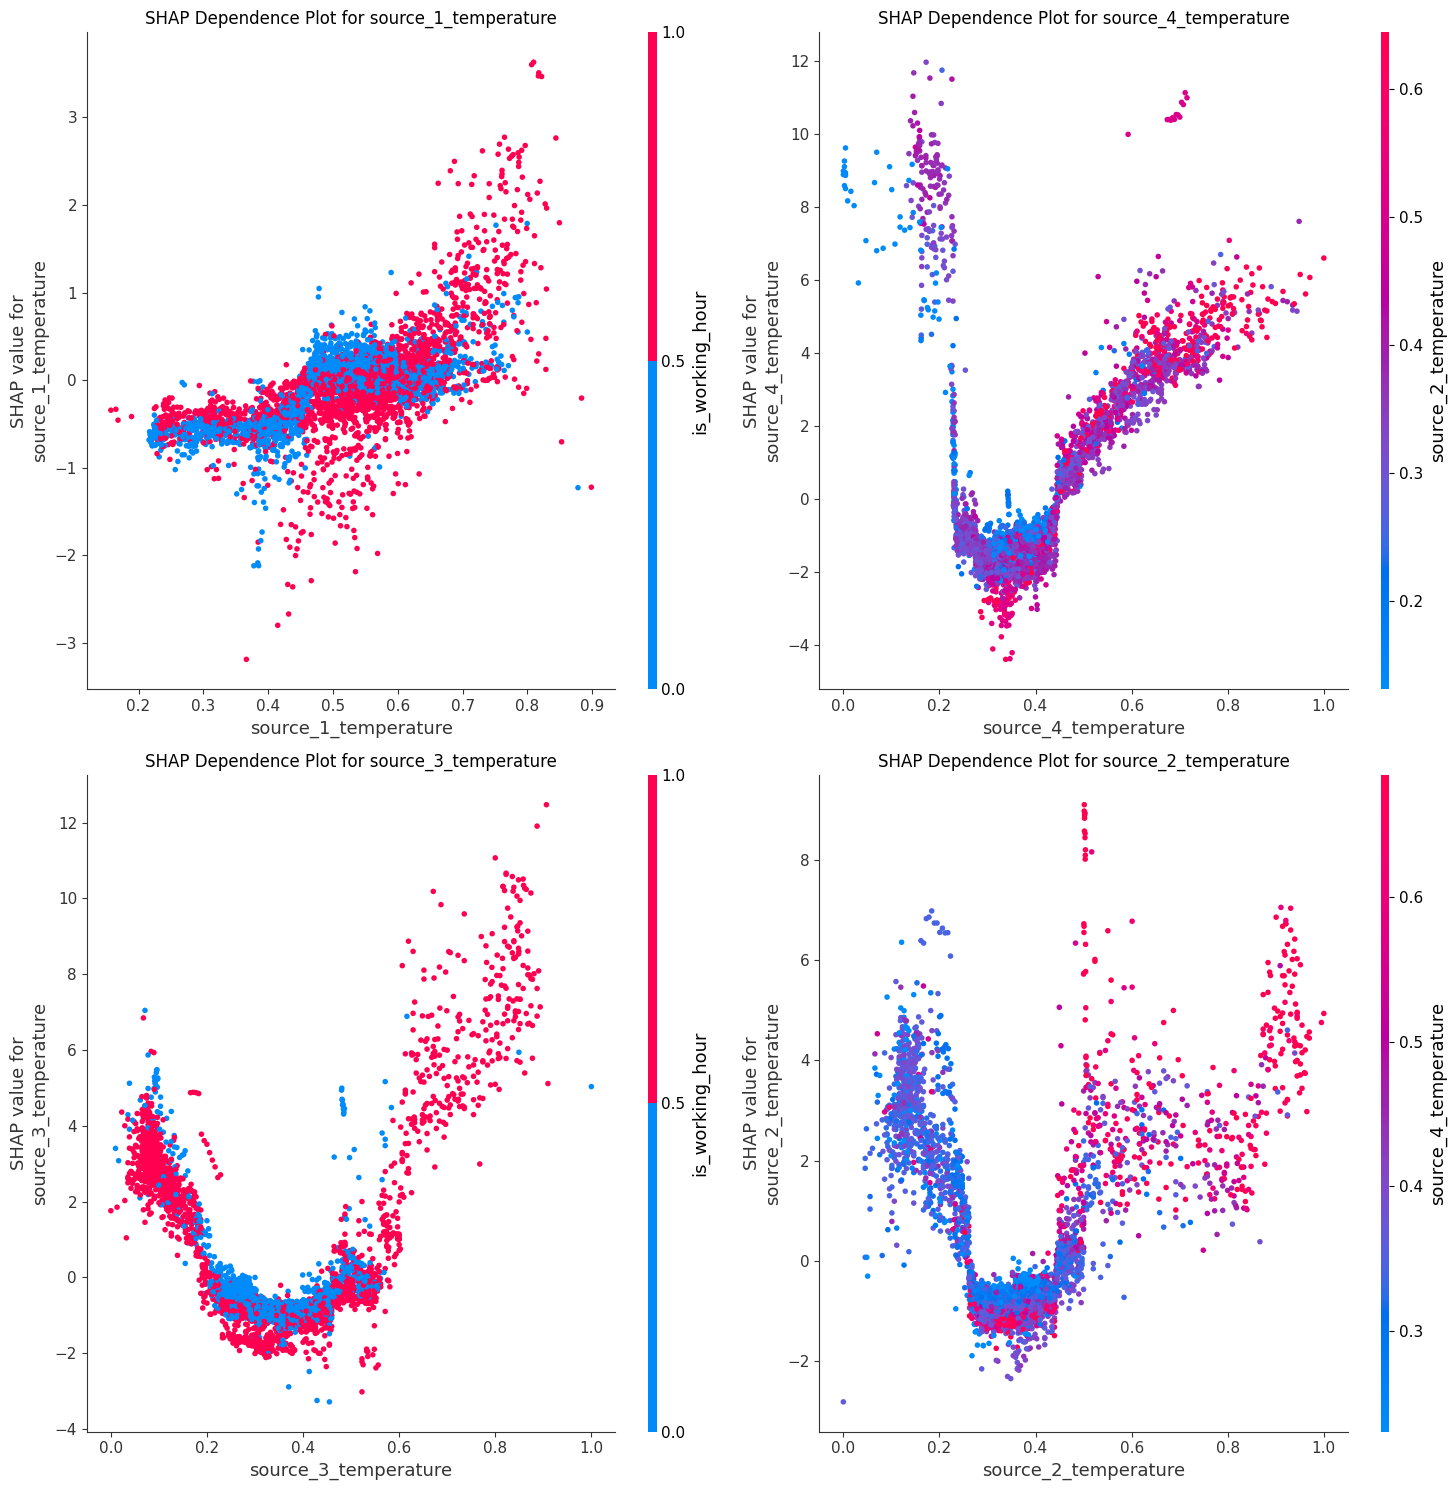

In [30]:
# Usage (a bit hard to interpret):
# First read the relationship between x and y (the feature itself and the shap value)
# Then the color basically plots as third dimension the feature that the source is the most correlated with among all features. The vertical dispersion in SHAP values seen for fixed variable values is due to interaction effects with other features. If you look at source 1 I think it's pretty clear that that's a heater inside the rooms themselves.
# For the rest idk lol

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for i, source in enumerate(['source_1_temperature', 'source_4_temperature', 
                          'source_3_temperature', 'source_2_temperature']):
    shap.dependence_plot(source, shap_values, X_train, ax=axes[i], show=False)
    axes[i].set_title(f'SHAP Dependence Plot for {source}')
    

plt.tight_layout()
plt.show()

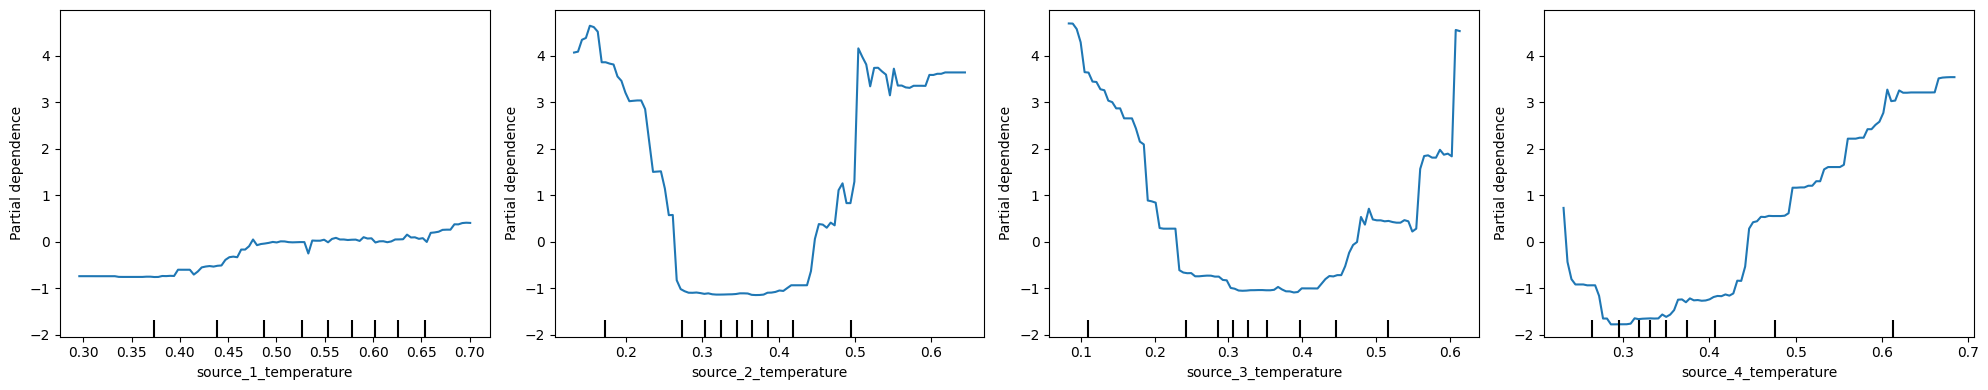

In [31]:
# Usage: 
# This is basically how the model's predictions change as a feature varies, 
# while keeping all other features constant (at their average value)
# The y-axis shows the change in the predicted target variable

from sklearn.inspection import PartialDependenceDisplay

source_cols = ['source_1_temperature', 'source_2_temperature', 
            'source_3_temperature', 'source_4_temperature']
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
pdp_display = PartialDependenceDisplay.from_estimator(model, X_train, source_cols, ax=ax)
plt.tight_layout()
plt.show()

In [32]:
min_scenario_values = pd.Series({
    'source_1_temperature': pdp_display.lines_[0].get_xdata()[np.argmin(pdp_display.lines_[0].get_ydata())],
    'source_2_temperature': pdp_display.lines_[1].get_xdata()[np.argmin(pdp_display.lines_[1].get_ydata())],
    'source_3_temperature': pdp_display.lines_[2].get_xdata()[np.argmin(pdp_display.lines_[2].get_ydata())],
    'source_4_temperature': pdp_display.lines_[3].get_xdata()[np.argmin(pdp_display.lines_[3].get_ydata())]
})
print(min_scenario_values)

source_1_temperature    0.373594
source_2_temperature    0.369894
source_3_temperature    0.388465
source_4_temperature    0.285472
dtype: float64


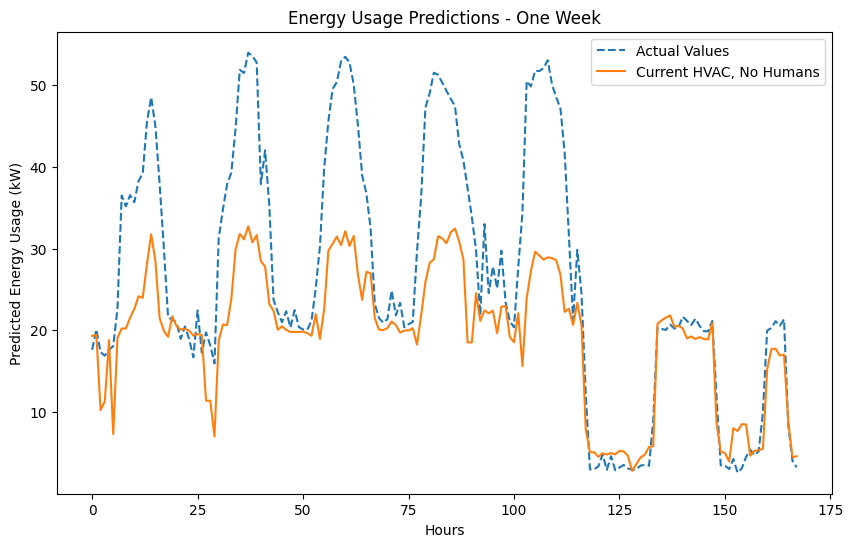

In [33]:
# 1) Current Environment, No Humans
# We don't touch weather or other conditions, just turn off human signals in X_val
X_val_no_humans = X_val.copy()
X_val_no_humans['is_working_day'] = 0
X_val_no_humans['is_working_hour'] = 0

# Keep the rest (HVAC and environment) as is, and predict
pred_no_humans_current_env = model.predict(X_val_no_humans)

# Plot
plt.figure(figsize=(10,6))
plt.plot(y_val[:24*7], label='Actual Values', linestyle='--')
plt.plot(pred_no_humans_current_env[:24*7], label='Current HVAC, No Humans')
plt.xlabel('Hours')
plt.ylabel('Predicted Energy Usage (kW)')
plt.title('Energy Usage Predictions - One Week')
plt.legend()
plt.show()


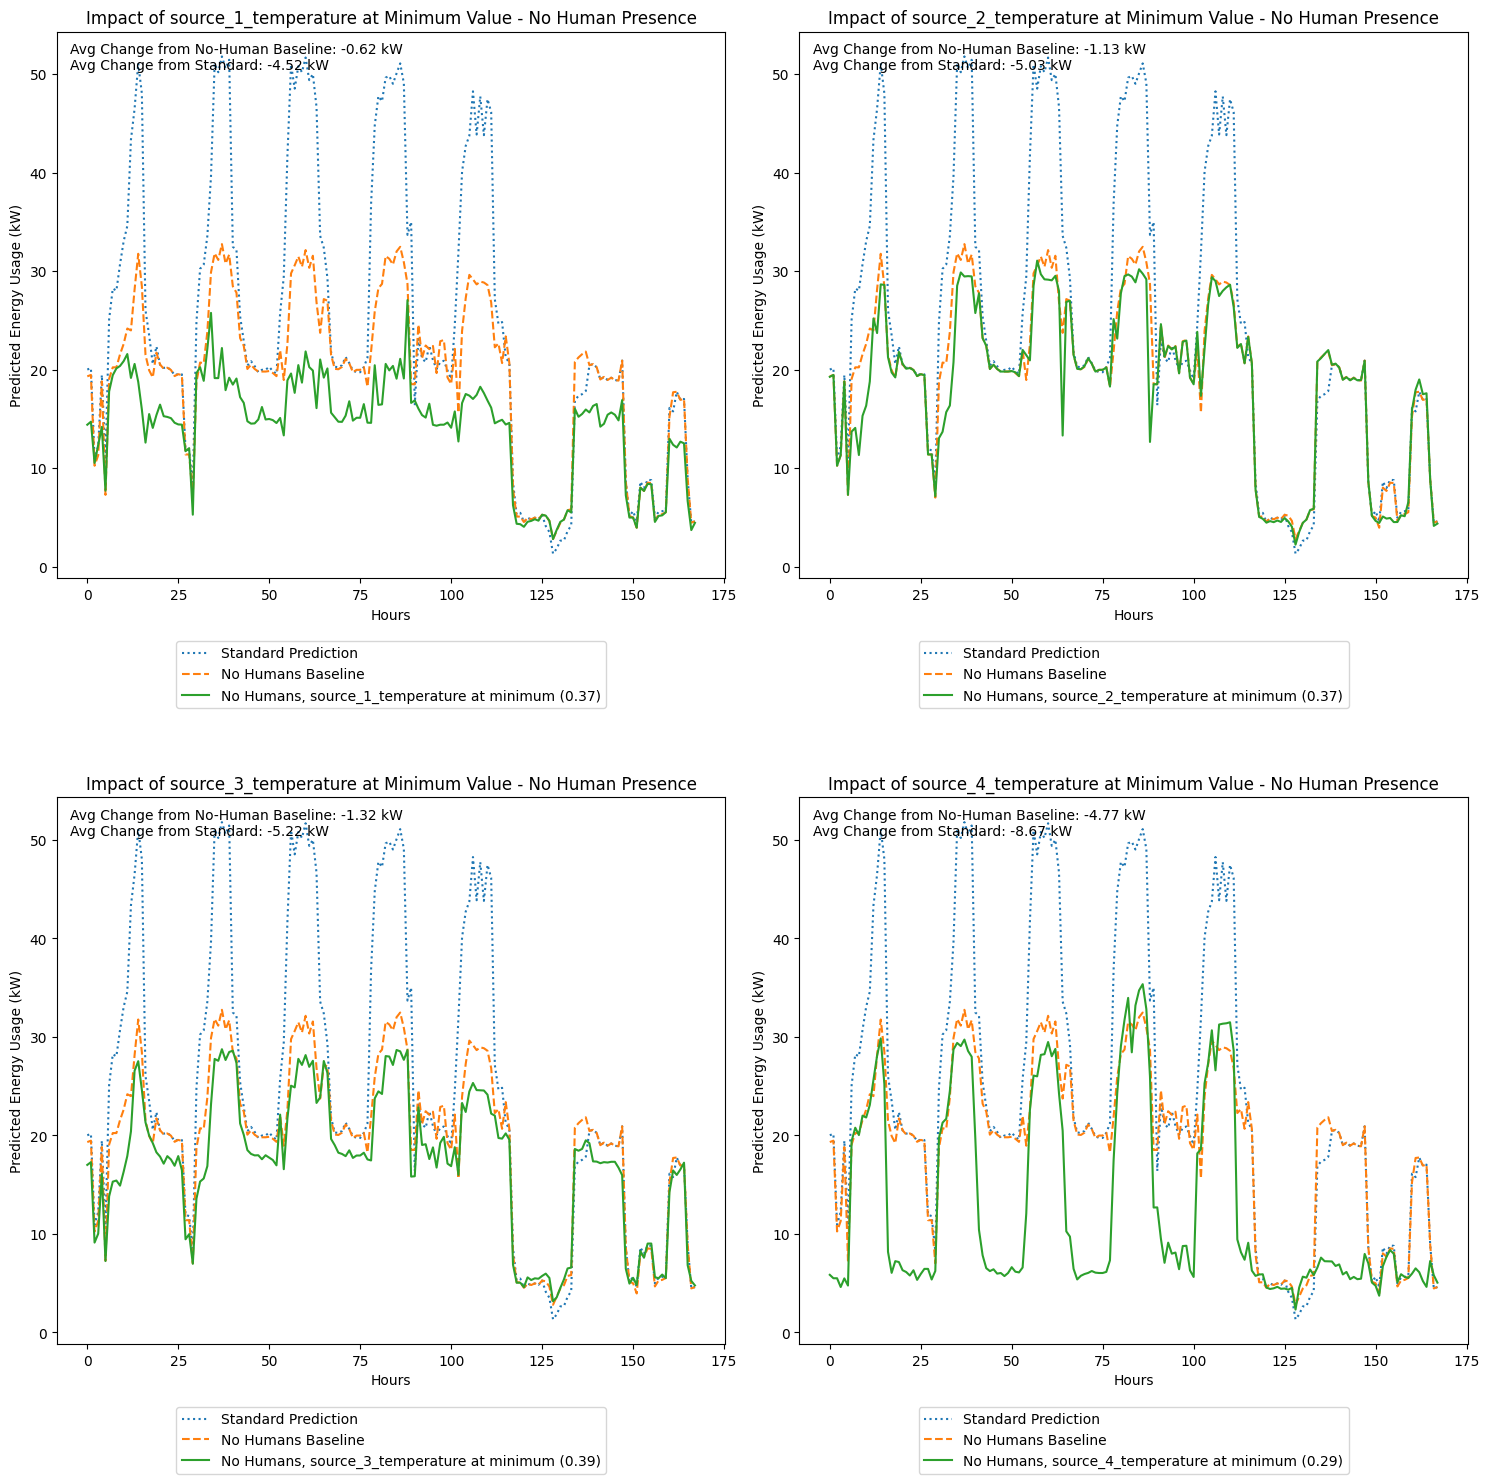

In [34]:
# 2) No humans, each source to its minimum value individually
source_cols = ['source_1_temperature', 'source_2_temperature', 'source_3_temperature', 'source_4_temperature']

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

# standard prediction for comparison
standard_pred = model.predict(X_val)

for i, source in enumerate(source_cols):
    X_val_min_source = X_val_no_humans.copy()
    X_val_min_source[source] = min_scenario_values[source]
    pred_min_source = model.predict(X_val_min_source)
    
    line1, = axes[i].plot(standard_pred[:24*7], linestyle=':', label='Standard Prediction')
    line2, = axes[i].plot(pred_no_humans_current_env[:24*7], linestyle='--', label='No Humans Baseline')
    line3, = axes[i].plot(pred_min_source[:24*7], 
                         label=f'No Humans, {source} at minimum ({min_scenario_values[source]:.2f})')
    
    axes[i].set_xlabel('Hours')
    axes[i].set_ylabel('Predicted Energy Usage (kW)')
    axes[i].set_title(f'Impact of {source} at Minimum Value - No Human Presence')
    
    # average changes
    avg_change_from_baseline = (pred_min_source - pred_no_humans_current_env).mean()
    avg_change_from_standard = (pred_min_source - standard_pred).mean()
    axes[i].text(0.02, 0.98, f'Avg Change from No-Human Baseline: {avg_change_from_baseline:.2f} kW\n' +
                             f'Avg Change from Standard: {avg_change_from_standard:.2f} kW', 
                transform=axes[i].transAxes, 
                verticalalignment='top')
    
    axes[i].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25))

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, bottom=0.1)
plt.show()

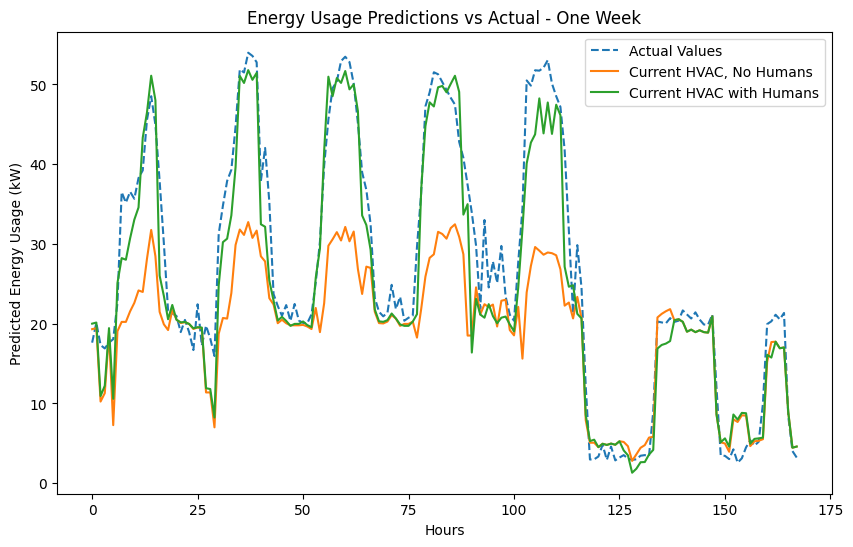

In [35]:
# 3) Humans Present Scenario
# Use the actual values from the validation set 
X_val_humans = X_val.copy()
pred_humans_current_env = model.predict(X_val_humans)

# Plot all three scenarios together for one week, plus actual values
plt.figure(figsize=(10,6))
plt.plot(y_val[:24*7], label='Actual Values', linestyle='--')
plt.plot(pred_no_humans_current_env[:24*7], label='Current HVAC, No Humans') 
plt.plot(pred_humans_current_env[:24*7], label='Current HVAC with Humans')
plt.xlabel('Hours')
plt.ylabel('Predicted Energy Usage (kW)')
plt.title('Energy Usage Predictions vs Actual - One Week')
plt.legend()
plt.show()


In [36]:
# Compute differences for humans and each source
Human_factor = pred_humans_current_env - pred_no_humans_current_env

# Compute source differences using min scenario predictions
source_factors = {}
for source in source_cols:
    X_val_min_source = X_val_no_humans.copy()
    X_val_min_source[source] = min_scenario_values[source]
    pred_min_source = model.predict(X_val_min_source)
    source_factors[source] = pred_no_humans_current_env - pred_min_source

# Print aggregate impacts
print(f"Estimated human-related incremental usage: {np.mean(Human_factor):.2f} kW")
print("\nEstimated source-related incremental usage:")
for source in source_cols:
    print(f"{source}: {np.mean(source_factors[source]):.2f} kW")



Estimated human-related incremental usage: 3.90 kW

Estimated source-related incremental usage:
source_1_temperature: 0.62 kW
source_2_temperature: 1.13 kW
source_3_temperature: 1.32 kW
source_4_temperature: 4.77 kW


<Figure size 1000x600 with 0 Axes>

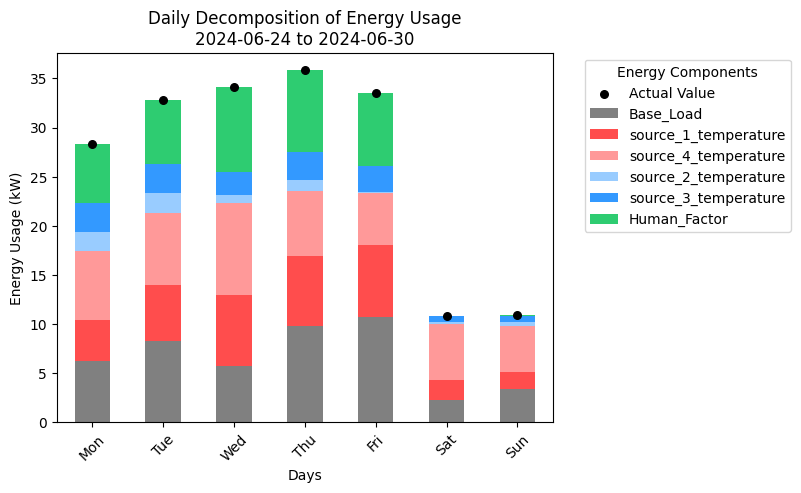

In [52]:
# Function to get data for a specific week
def get_week_data(week_num, Human_factor, source_factors, y_val):
    start_idx = week_num * 24 * 7
    end_idx = start_idx + (24 * 7)
    
    # Calculate daily aggregates for selected week
    daily_human_factor = [np.mean(Human_factor[i:i+24]) for i in range(start_idx, end_idx, 24)]
    daily_source_factors = {}
    for source in source_cols:
        daily_source_factors[source] = [np.mean(source_factors[source][i:i+24]) for i in range(start_idx, end_idx, 24)]
    
    daily_actual = [np.mean(y_val[i:i+24]) for i in range(start_idx, end_idx, 24)]
    adjusted_factors = {**{source: [] for source in source_cols}, 'Human_Factor': []}  # put Human_Factor last
    remaining_base = []

    for day in range(7):
        # Start with the total prediction for the day
        total = daily_actual[day]
        day_factors = {'Human_Factor': daily_human_factor[day]}
        for source in source_cols:
            day_factors[source] = daily_source_factors[source][day]
        
        # Adjust negative values
        for factor_name, value in day_factors.items():
            if value < 0:
                adjusted_factors[factor_name].append(0)
            else:
                adjusted_factors[factor_name].append(value)
        
        remaining_base.append(total - sum(adjusted_factors[f][day] for f in adjusted_factors.keys()))

    return {
        'Base_Load': remaining_base,
        **adjusted_factors
    }, daily_actual

start_date = pd.Timestamp('2024-06-24')
week_start = start_date + pd.Timedelta(weeks=0)
week_end = week_start + pd.Timedelta(days=6)

week_data, daily_actual = get_week_data(0, Human_factor, source_factors, y_val)
df_week = pd.DataFrame(week_data)

plt.figure(figsize=(10,6))
colors = [
    '#808080',  # Base load (gray)
    '#ff4d4d',  # Source 1 (darker red)
    '#ff9999',  # Source 4 (light red)
    '#99ccff',  # Source 2 (light blue)
    '#3399ff',  # Source 3 (darker blue)
    '#2ecc71'   # Human factor (green)
]

# Reorder columns for the stacked bar plot
column_order = [
    'Base_Load',
    'source_1_temperature',
    'source_4_temperature',
    'source_2_temperature',
    'source_3_temperature',
    'Human_Factor'
]

df_week[column_order].plot(kind='bar', stacked=True, color=colors)

plt.scatter(range(len(days)), daily_actual, color='black', marker='o', s=30, label='Actual Value', zorder=5)
plt.xlabel('Days')
plt.ylabel('Energy Usage (kW)')
plt.title(f'Daily Decomposition of Energy Usage\n{week_start.strftime("%Y-%m-%d")} to {week_end.strftime("%Y-%m-%d")}')
plt.legend(title='Energy Components', bbox_to_anchor=(1.05, 1), loc='upper left')

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(range(len(days)), days, rotation=45)
plt.show()
